# Directional Change using ATR for price movements




# Params

In [1]:
num_candles_to_load=0 #10000
timeframe="1min"
ema_slow=30
ema_fast=10

spread=8*1e-5
min_price_diff=spread*3 #=0.8pip

dc_mode="const" #can be const, minmax, atr

# for dc_mode==atr
atr_scale_eps=1
atr_n=20

# for dc_mode==minmax
minmax_band_scale=0.5
minmax_nlen=100

# for dc_mode== const
const_eps=0.05 #% if dc_mode is const

#these values will be used later for hiplot descriptions. 
eps_setting=minmax_band_scale


In [2]:
import numpy as np
import sys
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import helpers
import pandas_ta as ta
import pickle


In [3]:
#load data
candles_in=helpers.load_file("./data/forex/2020/gbpusd/gbpusd_1m_2020.csv", summary=timeframe)
print("loaded "+str(candles_in.shape[0])+" candles")
#candles_in=candles.iloc[:1000]
#candles_in=candles_in.set_index("time", drop=False)
candles_in.head()

loaded 361525 candles


open     high      low    close                time  vol       hl2  \
0  1.32463  1.32464  1.32462  1.32463 2020-01-01 23:03:00    0  1.324630   
1  1.32463  1.32466  1.32462  1.32466 2020-01-01 23:04:00    0  1.324640   
2  1.32466  1.32466  1.32463  1.32463 2020-01-01 23:05:00    0  1.324645   
3  1.32465  1.32466  1.32462  1.32462 2020-01-01 23:06:00    0  1.324640   
4  1.32462  1.32470  1.32462  1.32463 2020-01-01 23:07:00    0  1.324660   

    month  
0  2020-1  
1  2020-1  
2  2020-1  
3  2020-1  
4  2020-1

### Plot the log ret hist

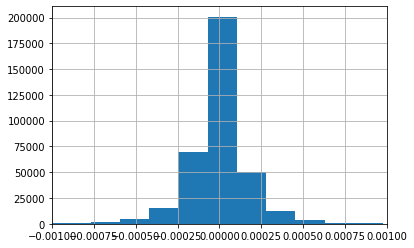

In [4]:
logret=np.log(candles_in["close"])-np.log(candles_in["close"].shift(1))
plt.hist(logret, bins=120)
plt.grid()
plt.xlim([-0.001, 0.001])
plt.show()

Compute the ATR indicator

In [5]:
candles_in["atr"]=candles_in.ta.atr(length=atr_n)
candles_in.tail()

open     high      low    close                time  vol       hl2  \
506871  1.34975  1.34989  1.34966  1.34970 2020-12-18 22:54:00    0  1.349775   
506872  1.34970  1.34994  1.34969  1.34982 2020-12-18 22:55:00    0  1.349815   
506873  1.34983  1.35083  1.34973  1.35077 2020-12-18 22:56:00    0  1.350280   
506874  1.35074  1.35239  1.35072  1.35239 2020-12-18 22:57:00    0  1.351555   
506875  1.35238  1.35326  1.35180  1.35310 2020-12-18 22:58:00    0  1.352530   

          month       atr  
506871  2020-12  0.000171  
506872  2020-12  0.000175  
506873  2020-12  0.000221  
506874  2020-12  0.000294  
506875  2020-12  0.000352

# Compute Renko and DC Events

Here we compute the so called `Renko` prices. Basically the `Directional Change`, where at least $\epsilon_{up}$  %  or $\epsilon_{down}$ % are between two price points in time.

![img](https://upload.wikimedia.org/wikipedia/commons/0/09/Directional-change_dissection_procedure.png)

The Directional Change (DC) and the Overshoot (OS) events are marked instantly in the same DataFrame.



In [6]:
def renko_segment(df, colname="close", atr_scale_eps=1.0):
    """
    segments the price movements into delta chunks of size threshold.
    means, a new sample is started only if the price moves `threshold` away from the anchor price.
    threshold: in %. e.g. 0.1
    """
    df2=df.copy()
    prices=[]
    deviations=[]
    dtimes=[]
    last_anchor=df.iloc[0][colname]
    last_atr=df.iloc[0]["atr"]
    last_ki=0
    events=[]
    last_event=None
    recomputing_needed=False
    for ki, vi in df.iterrows():
        ri=vi[colname] # ri: current price
        #print(ki)
        #print("ri: "+str(ri))
        #print("ki: "+str(ki))
        dt=ki-last_ki
        if ki==0:
            band_up=ri
        
        #if dt>1000:
        #    dt=0
        if ri >= band_up:
            
            #label the DC event
            #print("long, last_event: "+str(last_event))
            
            if last_event!=None and last_event=="dcup" or last_event=="osu":
                events.append("osu")
            else:
                events.append("dcup")
            last_event=events[-1]
            #print("new event after long: "+str(events[-1]))
            
            prices.append(ri)
            deviations.append(np.abs(ri-band_up))
            dtimes.append(dt)
            last_anchor=ri
            last_ki=ki
            last_atr=vi["atr"]
            recomputing_needed=True
            
        elif ri< band_down:
            #print("short, last_event: "+str(last_event))
            #label the DC event
            if last_event!=None and last_event=="dcdown" or last_event=="osd":
                events.append("osd")
            else:
                #print("down?: p[-2]: "+str(prices[-2])+", "+"p[-1]: "+str(prices[-1]))
                events.append("dcdown")
            last_event=events[-1]
            #print("new event after short: "+str(events[-1]))
            prices.append(ri)
            deviations.append(np.abs(ri-band_down))
            dtimes.append(dt)
            last_anchor=ri
            last_ki=ki
            vi["atr"]
            recomputing_needed=True
        else:
            #print("skip")
            prices.append(np.nan)
            dtimes.append(np.nan)
            events.append(np.nan)
            deviations.append(np.nan)
            
        if recomputing_needed:
            if dc_mode=="atr":
                band_up=last_anchor +np.max([min_price_diff, last_atr *atr_scale_eps])
                band_down=last_anchor -np.max([min_price_diff, last_atr *atr_scale_eps])
            elif dc_mode=="const":
                band_up=last_anchor + np.max([min_price_diff, last_anchor*const_eps/100])
                band_down=last_anchor - np.max([min_price_diff, last_anchor*const_eps/100])
            elif dc_mode=="minmax":
                if last_ki<(minmax_nlen+2):
                    band=min_price_diff
                else:
                    mn=df2[last_ki-minmax_nlen:last_ki]["close"].min()
                    mx=df2[last_ki-minmax_nlen:last_ki]["close"].max()
                    #print("last_ki: "+str(last_ki)+", ki: "+str(ki))
                    #print("mn: "+str(mn)+", mx: "+str(mx))
                    band=(mx-mn)
                #print("band: "+str(band))
                #raise Exception("stop")
                eps_minmax=np.max([band*minmax_band_scale, min_price_diff])
                band_up =last_anchor +  eps_minmax
                band_down =last_anchor -  eps_minmax
                #print("last_anchor: "+str(last_anchor)+", band_up: "+str(band_up)+", band_down: "+str(band_down))
                #print("np.max: "+str(np.max([band*minmax_band_scale, min_price_diff])))
                #print("band: "+str(band)+", arr: "+str([band*minmax_band_scale, min_price_diff]))
                #print("min_price_diff: "+str(min_price_diff))
        
    df2["renko_price"]=prices
    df2["event"]=events
    df2["renko_dt"]=dtimes
    df2["deviation"]=deviations
    return df2



In [7]:
df2=renko_segment(candles_in, atr_scale_eps=atr_scale_eps)
df2.dropna(inplace=True)
df2.head(33)

open     high      low    close                time  vol       hl2  \
0    1.32463  1.32464  1.32462  1.32463 2020-01-01 23:03:00    0  1.324630   
59   1.32513  1.32542  1.32493  1.32535 2020-01-02 00:02:00    0  1.325175   
69   1.32583  1.32608  1.32581  1.32605 2020-01-02 00:12:00    0  1.325945   
83   1.32557  1.32562  1.32533  1.32534 2020-01-02 00:26:00    0  1.325475   
169  1.32599  1.32610  1.32596  1.32603 2020-01-02 01:52:00    0  1.326030   
229  1.32537  1.32543  1.32532  1.32535 2020-01-02 02:52:00    0  1.325375   
255  1.32470  1.32470  1.32462  1.32463 2020-01-02 03:18:00    0  1.324660   
312  1.32412  1.32418  1.32393  1.32393 2020-01-02 04:15:00    0  1.324055   
317  1.32331  1.32336  1.32304  1.32311 2020-01-02 04:20:00    0  1.323200   
327  1.32256  1.32256  1.32156  1.32201 2020-01-02 04:30:00    0  1.322060   
328  1.32209  1.32214  1.32123  1.32127 2020-01-02 04:31:00    0  1.321685   
346  1.32134  1.32135  1.32053  1.32053 2020-01-02 04:49:00    0  1.320940   
373  1.32113  1.32163  1.32113  1.32149 2020-01-02 05:16:00    0  1.321380   
412  1.32092  1.32092  1.32053  1.32071 2020-01-02 05:55:00    0  1.320725   
479  1.32136  1.32156  1.32136  1.32154 2020-01-02 07:02:00    0  1.321460   
490  1.32217  1.32226  1.32200  1.32221 2020-01-02 07:13:00    0  1.322130   
498  1.32171  1.32176  1.32136  1.32145 2020-01-02 07:21:00    0  1.321560   
511  1.32096  1.32096  1.32076  1.32076 2020-01-02 07:34:00    0  1.320860   
527  1.32104  1.32158  1.32104  1.32147 2020-01-02 07:50:00    0  1.321310   
530  1.32166  1.32216  1.32166  1.32216 2020-01-02 07:53:00    0  1.321910   
557  1.32231  1.32293  1.32230  1.32293 2020-01-02 08:20:00    0  1.322615   
564  1.32238  1.32249  1.32188  1.32201 2020-01-02 08:27:00    0  1.322185   
568  1.32197  1.32207  1.32094  1.32117 2020-01-02 08:31:00    0  1.321505   
576  1.32179  1.32196  1.32178  1.32196 2020-01-02 08:39:00    0  1.321870   
599  1.32208  1.32265  1.32197  1.32263 2020-01-02 09:02:00    0  1.322310   
604  1.32199  1.32199  1.32186  1.32187 2020-01-02 09:07:00    0  1.321925   
610  1.32137  1.32137  1.32108  1.32117 2020-01-02 09:13:00    0  1.321225   
615  1.32137  1.32248  1.32136  1.32213 2020-01-02 09:18:00    0  1.321920   
621  1.32150  1.32160  1.32124  1.32124 2020-01-02 09:24:00    0  1.321420   
633  1.32182  1.32198  1.32181  1.32194 2020-01-02 09:36:00    0  1.321895   
648  1.32235  1.32267  1.32228  1.32267 2020-01-02 09:51:00    0  1.322475   
666  1.32218  1.32218  1.32186  1.32186 2020-01-02 10:09:00    0  1.322020   
714  1.32123  1.32127  1.32112  1.32113 2020-01-02 10:57:00    0  1.321195   

      month       atr  renko_price   event  renko_dt  deviation  
0    2020-1  0.000020      1.32463    dcup       0.0   0.000000  
59   2020-1  0.000188      1.32535     osu      59.0   0.000058  
69   2020-1  0.000169      1.32605     osu      10.0   0.000037  
83   2020-1  0.000130      1.32534  dcdown      14.0   0.000047  
169  2020-1  0.000177      1.32603    dcup      86.0   0.000027  
229  2020-1  0.000169      1.32535  dcdown      60.0   0.000017  
255  2020-1  0.000145      1.32463     osd      26.0   0.000057  
312  2020-1  0.000144      1.32393     osd      57.0   0.000038  
317  2020-1  0.000180      1.32311     osd       5.0   0.000158  
327  2020-1  0.000224      1.32201     osd      10.0   0.000438  
328  2020-1  0.000258      1.32127     osd       1.0   0.000079  
346  2020-1  0.000249      1.32053     osd      18.0   0.000079  
373  2020-1  0.000231      1.32149    dcup      27.0   0.000300  
412  2020-1  0.000182      1.32071  dcdown      39.0   0.000119  
479  2020-1  0.000147      1.32154    dcup      67.0   0.000170  
490  2020-1  0.000179      1.32221     osu      11.0   0.000009  
498  2020-1  0.000204      1.32145  dcdown       8.0   0.000099  
511  2020-1  0.000201      1.32076     osd      13.0   0.000029  
527  2020-1  0.000220      1.32147    dcup      16.0   0.000050  
530  2020-1  0.000264      1.32216 

In [8]:

candles=df2.reset_index() #overwrite the candles by the renko df (the scripts below all rely on the `candles` variable)

Lets have alook on the result. It contains now the prices at the time points when the $\epsilon$ threshold is hit,
the event name in the `event` column and the time difference between the events in the `renko_dt` column:

In [9]:
candles.head(10)

index     open     high      low    close                time  vol  \
0      0  1.32463  1.32464  1.32462  1.32463 2020-01-01 23:03:00    0   
1     59  1.32513  1.32542  1.32493  1.32535 2020-01-02 00:02:00    0   
2     69  1.32583  1.32608  1.32581  1.32605 2020-01-02 00:12:00    0   
3     83  1.32557  1.32562  1.32533  1.32534 2020-01-02 00:26:00    0   
4    169  1.32599  1.32610  1.32596  1.32603 2020-01-02 01:52:00    0   
5    229  1.32537  1.32543  1.32532  1.32535 2020-01-02 02:52:00    0   
6    255  1.32470  1.32470  1.32462  1.32463 2020-01-02 03:18:00    0   
7    312  1.32412  1.32418  1.32393  1.32393 2020-01-02 04:15:00    0   
8    317  1.32331  1.32336  1.32304  1.32311 2020-01-02 04:20:00    0   
9    327  1.32256  1.32256  1.32156  1.32201 2020-01-02 04:30:00    0   

        hl2   month       atr  renko_price   event  renko_dt  deviation  
0  1.324630  2020-1  0.000020      1.32463    dcup       0.0   0.000000  
1  1.325175  2020-1  0.000188      1.32535     osu      59.0   0.000058  
2  1.325945  2020-1  0.000169      1.32605     osu      10.0   0.000037  
3  1.325475  2020-1  0.000130      1.32534  dcdown      14.0   0.000047  
4  1.326030  2020-1  0.000177      1.32603    dcup      86.0   0.000027  
5  1.325375  2020-1  0.000169      1.32535  dcdown      60.0   0.000017  
6  1.324660  2020-1  0.000145      1.32463     osd      26.0   0.000057  
7  1.324055  2020-1  0.000144      1.32393     osd      57.0   0.000038  
8  1.323200  2020-1  0.000180      1.32311     osd       5.0   0.000158  
9  1.322060  2020-1  0.000224      1.32201     osd      10.0   0.000438

Lets compute simple EMACD indicator **on the resulting renko events**.

In [10]:
candles["ema_slow"]=candles.ta.sma(length=ema_slow)
candles["ema_fast"]=candles.ta.sma(length=ema_fast)
candles["emacd"]=candles["ema_fast"]-candles["ema_slow"]
candles=candles.dropna()

In [11]:
dc_ma=[]
nback=30
for k,v in candles.iterrows():
    #print("k: "+str(k))
    #print("v: "+str(v["event"]))
    i=candles.index.get_loc(k)
    #print("i: "+str(i))
    events=candles.iloc[i-nback:i]["event"].values
    #print(events)
    #num_osup=len(np.where(events=="osu")[0])
    #num_osdown=len(np.where(events=="osd")[0])
    num_dc=len(np.where(events=="dcup")[0])+len(np.where(events=="dcdown")[0])
    num_dc=num_dc/float(nback)
    dc_ma.append(num_dc)
    #print("num_osup: "+str(num_osup))
    
candles["dc_ma"]=dc_ma
#compute the moving avg 


## Moving average of the relative amount of DC wrt. all events

This shows, how effective or ineffective it would be to bet on a reversal or a trend (=overshoot)


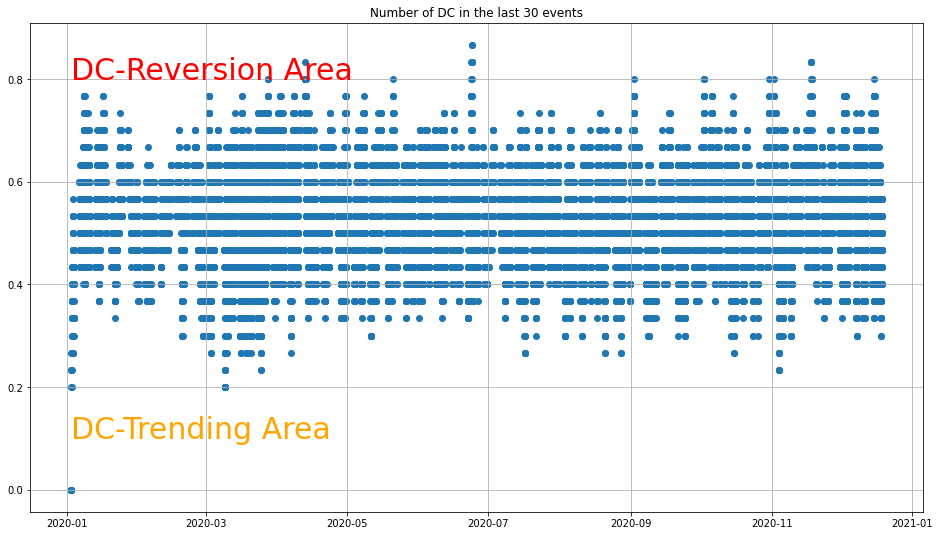

In [12]:
f, ax = plt.subplots(1, sharex=True, sharey=False, figsize=(16, 9))
ax.scatter(candles["time"], candles["dc_ma"])
ax.grid()
ax.set_title("Number of DC in the last "+str(nback)+" events")
ax.text(candles["time"].values[10], 0.8, s="DC-Reversion Area", fontsize=30, color="red")
ax.text(candles["time"].values[10], 0.1, s="DC-Trending Area", fontsize=30, color="orange")

plt.show()

In [13]:
candles.reset_index(inplace=True)
candles.tail()

level_0   index     open     high      low    close  \
25226    25255  506848  1.34899  1.34915  1.34899  1.34914   
25227    25256  506872  1.34970  1.34994  1.34969  1.34982   
25228    25257  506873  1.34983  1.35083  1.34973  1.35077   
25229    25258  506874  1.35074  1.35239  1.35072  1.35239   
25230    25259  506875  1.35238  1.35326  1.35180  1.35310   

                     time  vol       hl2    month       atr  renko_price  \
25226 2020-12-18 22:31:00    0  1.349070  2020-12  0.000171      1.34914   
25227 2020-12-18 22:55:00    0  1.349815  2020-12  0.000175      1.34982   
25228 2020-12-18 22:56:00    0  1.350280  2020-12  0.000221      1.35077   
25229 2020-12-18 22:57:00    0  1.351555  2020-12  0.000294      1.35239   
25230 2020-12-18 22:58:00    0  1.352530  2020-12  0.000352      1.35310   

      event  renko_dt  deviation  ema_slow  ema_fast     emacd     dc_ma  
25226  dcup       4.0   0.000056  1.349061  1.349427  0.000366  0.566667  
25227   osu      24.0   0.000005  1.349063  1.349429  0.000366  0.566667  
25228   osu       1.0   0.000275  1.349131  1.349599  0.000468  0.533333  
25229   osu       1.0   0.000945  1.349280  1.349859  0.000579  0.500000  
25230   osu       1.0   0.000034  1.349476  1.350113  0.000637  0.500000

## Some Metrics

Seeking to answer following questions:
* How many OS in a row are there?
* Moving mean OS in a row


#### How many OSUP and OSDOWN where observed in a row?

In [14]:
##Compute prev OS for each sample
def count_os(item, suffix):
    idx=item.name
    if idx==0:
        return 0
    i=1
    while True:
        ridx=idx-i
        if ridx<=0:
            return 0
        ci=candles.loc[ridx]
        if "dc" in ci["event"]:
            return i-1
        elif "os"+suffix in ci["event"]:
            i+=1
        else:
            return i-1
#count also DCs in a row before each event
def count_dcs(item, suffix):
    idx=item.name
    if idx==0:
        return 0
    i=1
    while True:
        ridx=idx-i
        if ridx<=0:
            return 0
        ci=candles.loc[ridx]
        if "os" in ci["event"]:
            return i-1
        elif "dc"+suffix in ci["event"]:
            i+=1
        else:
            return i-1
        
print("candles: "+str(candles.shape))
candles["prev_osup"]=candles.apply(count_os, axis=1, raw=False, suffix="u")
candles["prev_osdown"]=candles.apply(count_os, axis=1, raw=False, suffix="d")

candles["prev_dcdown"]=candles.apply(count_dcs, axis=1, raw=False, suffix="d")
candles["prev_dcup"]=candles.apply(count_dcs, axis=1, raw=False, suffix="u")
candles["prev_dc"]=candles.apply(count_dcs, axis=1, raw=False, suffix="")







candles: (25231, 19)


## OSDown in a row
Now lets have a look on the distribution of prev_os and its maximal value:


max prev os down: 12
mean prev_os down: 0.43945939518845867


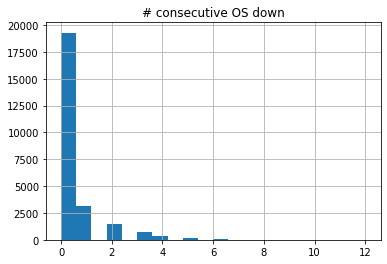

In [15]:
candles["prev_osdown"].hist(bins=20)
plt.title("# consecutive OS down")
mx=candles["prev_osdown"].max()
print("max prev os down: "+str(mx))
print("mean prev_os down: "+str(candles["prev_osdown"].mean()))

Tha means, that if we develop a strategy on DC-reversion, the strategy will have to be prepared to survive at least 11 wrong trades in a row!

### Plot sliding-window of the number of consecutive OSDOWNs

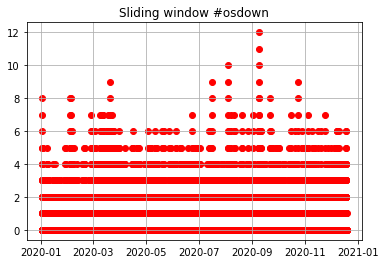

In [16]:
plt.scatter(candles["time"], candles["prev_osdown"], color="red")
plt.title("Sliding window #osdown")
plt.grid()

## OS UP in a row

max prev os up: 14
mean prev_os up: 0.4433435060045183


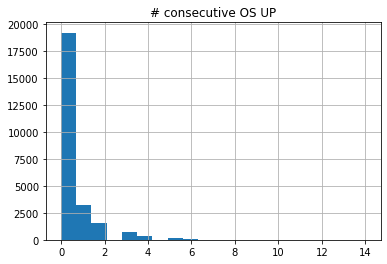

In [17]:
candles["prev_osup"].hist(bins=20)
plt.title("# consecutive OS UP")
mx=candles["prev_osup"].max()
print("max prev os up: "+str(mx))
print("mean prev_os up: "+str(candles["prev_osup"].mean()))

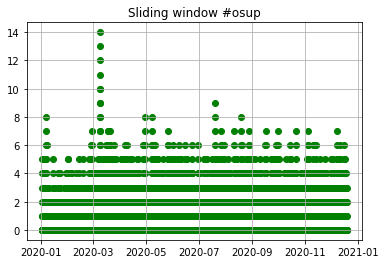

In [18]:
plt.scatter(candles["time"], candles["prev_osup"], color="green")
plt.title("Sliding window #osup")
plt.grid()

## DC in a row


max prev dc: 12
mean prev_dc: 1.0995204312155682


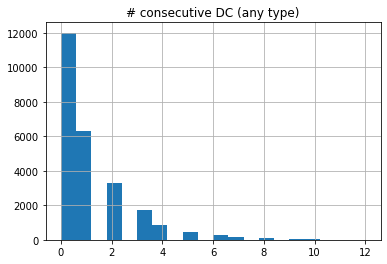

In [19]:
candles["prev_dc"].hist(bins=20)
plt.title("# consecutive DC (any type)")
mx=candles["prev_dc"].max()
print("max prev dc: "+str(mx))
print("mean prev_dc: "+str(candles["prev_dc"].mean()))


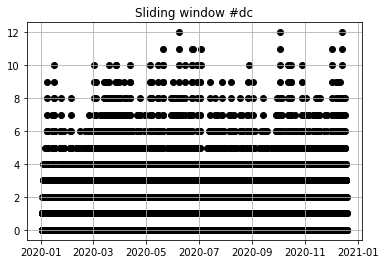

In [20]:
plt.scatter(candles["time"], candles["prev_dc"], color="k")
plt.title("Sliding window #dc")
plt.grid()

## How can we measure consecutive worst cases ?
e.g. when we get 8 DC in a row, then an overshoot, and then again 9 DC in a row. 
How to collect this distribution?


Text(0.5, 1.0, 'series of DC')

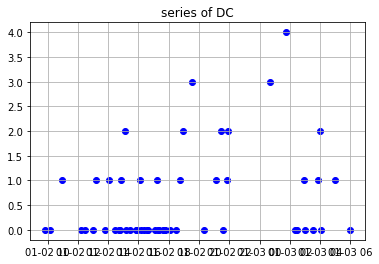

In [35]:
plt.scatter(candles["time"][:55], candles["prev_dc"][:55], color="blue")
plt.grid()
plt.title("series of DC")

In [100]:
def check_double_serial_dc(row, thr1, thr2):
    
    #print("row: "+str(row)+", thr1: "+str(thr1)+", thr2: "+str(thr2))
    #print("thr1: "+str(thr1)+", thr2: "+str(thr2))
    def find_dc2os_transitions(row, thr1, thr2):
        #locates the cases where  a value goes from x>1 to x=0
        transition_indicies=[]
        for ii in range(1, row.shape[0]):
            if len(transition_indicies)==0:
                thr=thr1
            else:
                thr=thr2
            if row[ii-1]>=thr and row[ii]==0:
                transition_indicies.append(ii)
                    
        return transition_indicies
    trans_idx=find_dc2os_transitions(row, thr1, thr2)
    #print(row)
    #print(trans_idx)
    if len(trans_idx)<2:
        return 0
    #now, between these two streak-ends, shall be two zeros, otherwise the strategy wont be able to recover
    val_range=row[trans_idx[0]:trans_idx[1]]
    num_zeros=np.where(val_range==0)[0].shape[0]
    #print("num: "+str(num_zeros))
    
    if num_zeros>=2:
        return 0
    #now remember this detection in order to avoid labeling the same stuff on the next rows
    elif trans_idx[1]==(row.shape[0]-1):
        #print("row: "+str(row)+", thr1: "+str(thr1)+", thr2: "+str(thr2))
        #print("detected")
        return 1
    else:
        return 0

    #print("????")
    #print("num: "+str(num_zeros))
    #print(trans_idx)
    
thr1=3 #how large a first anti-streak might get (num consecutive DCs)
thr2=2 #how large a second anti-stream might be.
candles["double_dc_streak"]=candles["prev_dc"].rolling(window=25).apply(check_double_serial_dc, raw=True, args=(thr1,thr2,))

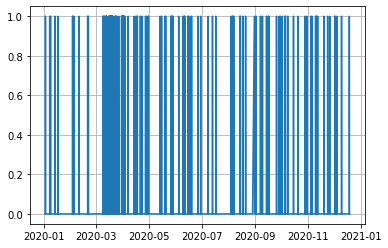

In [133]:
nc=-1
plt.plot(candles["time"][:nc], candles["double_dc_streak"][:nc])
plt.grid()

Collect the distribution of double streaks

In [128]:
lst1=[3,4,5,6,7,8]
lst2=[2,3,4,5,6,7,8]
res=np.zeros((len(lst1), len(lst2)))
for thr1_ in lst1:
    for thr2_ in lst2:
        sm=candles["prev_dc"].rolling(window=25).apply(check_double_serial_dc, raw=True, args=(thr1_,thr2_,)).sum()
        print("sm: "+str(sm))
        res[lst1.index(thr1_), lst2.index(thr2_)]=sm

         


sm: 125.0
sm: 74.0
sm: 47.0
sm: 29.0
sm: 22.0
sm: 13.0
sm: 2.0
sm: 119.0
sm: 69.0
sm: 38.0
sm: 25.0
sm: 14.0
sm: 10.0
sm: 2.0
sm: 81.0
sm: 46.0
sm: 23.0
sm: 16.0
sm: 9.0
sm: 6.0
sm: 2.0
sm: 57.0
sm: 31.0
sm: 15.0
sm: 10.0
sm: 5.0
sm: 4.0
sm: 2.0
sm: 35.0
sm: 21.0
sm: 11.0
sm: 7.0
sm: 3.0
sm: 3.0
sm: 2.0
sm: 16.0
sm: 9.0
sm: 6.0
sm: 4.0
sm: 2.0
sm: 2.0
sm: 1.0


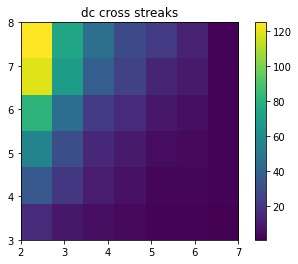

In [130]:
fig, ax = plt.subplots(1,1)
pos=ax.imshow(res, interpolation='none', extent=[lst2[0], lst2[-2], lst1[0], lst1[-1]])
#ax.grid()
ax.set_title("dc cross streaks")

#ax.set_xticks(lst2)
#ax.set_xticklabels(lst2)

#ax.set_yticklabels(lst1)
fig.colorbar(pos, ax=ax)

What do we see from the grid image above?
* there is at least one case where 8 DC-reversals are followed by one OS and then again by 8 DC-reversals. These are the situation we need to identify and to avoid by all means.


## Plotting log ret of the events

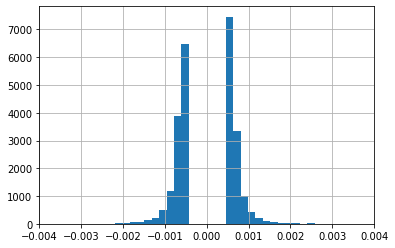

In [21]:
logret_dc=np.log(candles["close"])-np.log(candles["close"].shift(1))
plt.hist(logret_dc, bins=120)
plt.grid()
plt.xlim([-0.004, 0.004])
plt.show()

## Basic Plot of the Events
Now we plot the first `nfirst` of the computed renko prices for a better visual feeling.

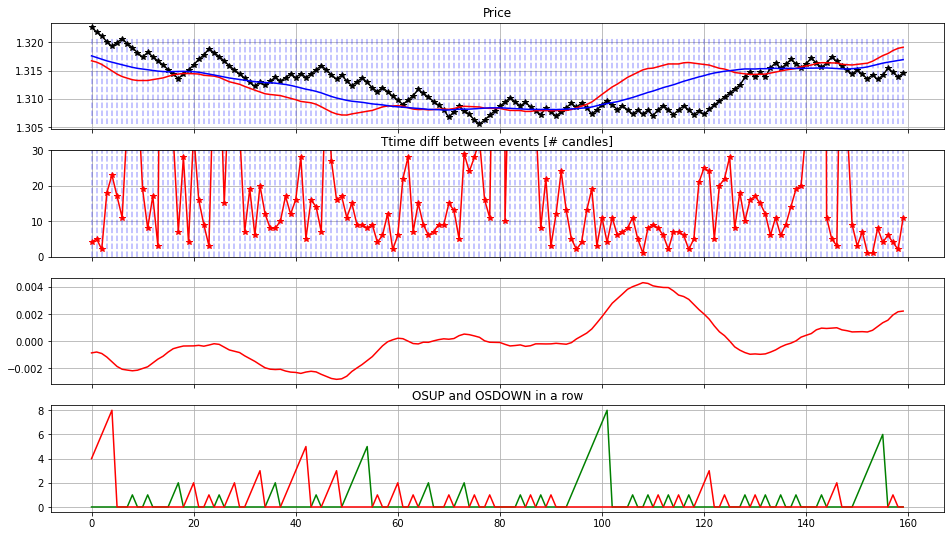

In [22]:
n0=ema_slow
nfirst=n0+160
f, [ax1, ax2, ax3, ax4] = plt.subplots(4, sharex=True, sharey=False, figsize=(16, 9))
ax1.plot(df2.iloc[n0:nfirst]["close"].values, label="Close", color="k", marker="*")
ax1.grid()
ax1.set_title("Price")
ax1.vlines(list(range(candles.iloc[n0:nfirst]["renko_price"].values.shape[0])), 
           np.min(candles.iloc[n0:nfirst]["renko_price"].values),  #ymin
           np.max(candles.iloc[n0:nfirst]["renko_price"].values),  #ymax
           colors='blue', linestyles='dashed', alpha=0.3)

ax2.plot(candles.iloc[n0:nfirst]["renko_dt"].values, color="red", label="renko_dt", marker="*")
ax2.grid()
ax2.vlines(list(range(candles.iloc[n0:nfirst]["renko_price"].values.shape[0])), 0, candles.iloc[:nfirst]["renko_dt"].max(), 
           colors='blue', linestyles='dashed', alpha=0.3)
ax2.set_title("Ttime diff between events [# candles]")
ax2.set_ylim([0,30])

#add also the EMA lines
ax1.plot(candles.iloc[n0:nfirst]["ema_fast"].values, label="EMA_fast", color="red")
ax1.plot(candles.iloc[n0:nfirst]["ema_slow"].values, label="EMA_slow", color="blue")


ax3.plot(candles.iloc[n0:nfirst]["emacd"].values, color="red", label="EMACD")
ax3.grid()

ax4.plot(candles.iloc[n0:nfirst]["prev_osup"].values, color="green", label="num OS before event")
ax4.plot(candles.iloc[n0:nfirst]["prev_osdown"].values, color="red", label="num OS before event")
ax4.set_title("OSUP and OSDOWN in a row")
ax4.grid()



## Inspect the ranges where the most OS in a row occured

These are the time where the market experienced the hardest volatility


In [23]:
abnormal_events=candles[(candles["prev_osup"]>4) | (candles["prev_osdown"]>4)]
abnormal_events.head(200)

level_0   index     open     high      low    close                time  \
19         48    1011  1.31358  1.31448  1.31358  1.31445 2020-01-02 15:54:00   
25         54    1082  1.31831  1.31831  1.31806  1.31818 2020-01-02 17:05:00   
31         60    1122  1.31429  1.31429  1.31369  1.31369 2020-01-02 17:45:00   
32         61    1124  1.31390  1.31398  1.31288  1.31291 2020-01-02 17:47:00   
33         62    1142  1.31245  1.31245  1.31220  1.31220 2020-01-02 18:05:00   
...       ...     ...      ...      ...      ...      ...                 ...   
9582     9611  158746  1.23984  1.24062  1.23984  1.24057 2020-04-21 04:49:00   
9608     9637  159148  1.23494  1.23551  1.23481  1.23547 2020-04-21 11:31:00   
9641     9670  159424  1.23201  1.23203  1.23115  1.23148 2020-04-21 16:07:00   
9650     9679  159464  1.22794  1.22832  1.22769  1.22826 2020-04-21 16:47:00   
9827     9856  161912  1.23163  1.23220  1.23163  1.23215 2020-04-23 09:35:00   

      vol       hl2   month  ...  deviation  ema_slow  ema_fast     emacd  \
19      0  1.314030  2020-1  ...   0.000223  1.319581  1.316161 -0.003420   
25      0  1.318185  2020-1  ...   0.000011  1.318584  1.316058 -0.002526   
31      0  1.313990  2020-1  ...   0.000073  1.317326  1.316509 -0.000817   
32      0  1.313430  2020-1  ...   0.000123  1.317027  1.316102 -0.000925   
33      0  1.312325  2020-1  ...   0.000054  1.316730  1.315541 -0.001189   
...   ...       ...     ...  ...        ...       ...       ...       ...   
9582    0  1.240230  2020-4  ...   0.000380  1.244685  1.242279 -0.002406   
9608    0  1.235160  2020-4  ...   0.000063  1.239439  1.237290 -0.002149   
9641    0  1.231590  2020-4  ...   0.000394  1.231147  1.229607 -0.001540   
9650    0  1.228005  2020-4  ...   0.000086  1.230221  1.230310  0.000089   
9827    0  1.231915  2020-4  ...   0.000134  1.234185  1.233862 -0.000323   

         dc_ma  prev_osup  prev_osdown  prev_dcdown  prev_dcup  prev_dc  
19    0.000000          0            5            0          0        0  
25    0.000000          5            0            0          0        0  
31    0.233333          0            5            0          0        0  
32    0.233333          0            6            0          0        0  
33    0.200000          0            7            0          0        0  
...        ...        ...          ...          ...        ...      ...  
9582  0.366667          0            5            0          0        0  
9608  0.533333          0            5            0          0        0  
9641  0.366667          5            0            0          0        0  
9650  0.366667          0            5            0          0        0  
9827  0.433333          0            5            0          0        0  

[200 rows x 24 columns]

## Inspect the areas where the time between the events was zero.

This is of intetest because the we are loosing accuracy if the next candle already changed that much to trigger an DC/OS event.


In [24]:
turbo_events=candles[candles["renko_dt"]<10]
turbo_events.head(200)

level_0  index     open     high      low    close                time  \
12        41    944  1.31773  1.31824  1.31773  1.31824 2020-01-02 14:47:00   
13        42    948  1.31778  1.31784  1.31747  1.31747 2020-01-02 14:51:00   
15        44    967  1.31660  1.31675  1.31600  1.31602 2020-01-02 15:10:00   
18        47   1010  1.31441  1.31447  1.31351  1.31357 2020-01-02 15:53:00   
19        48   1011  1.31358  1.31448  1.31358  1.31445 2020-01-02 15:54:00   
..       ...    ...      ...      ...      ...      ...                 ...   
415      444  12456  1.30864  1.30887  1.30851  1.30851 2020-01-10 14:39:00   
417      446  12476  1.30711  1.30736  1.30660  1.30661 2020-01-10 14:59:00   
419      448  12536  1.30631  1.30652  1.30629  1.30650 2020-01-10 15:59:00   
424      453  12612  1.30536  1.30555  1.30530  1.30552 2020-01-10 17:15:00   
431      460  15905  1.30416  1.30427  1.30416  1.30427 2020-01-13 00:08:00   

     vol       hl2   month  ...  deviation  ema_slow  ema_fast     emacd  \
12     0  1.317985  2020-1  ...   0.000181  1.320975  1.319387 -0.001588   
13     0  1.317655  2020-1  ...   0.000111  1.320841  1.319021 -0.001820   
15     0  1.316375  2020-1  ...   0.000022  1.320523  1.318350 -0.002173   
18     0  1.313990  2020-1  ...   0.000203  1.319815  1.316625 -0.003190   
19     0  1.314030  2020-1  ...   0.000223  1.319581  1.316161 -0.003420   
..   ...       ...     ...  ...        ...       ...       ...       ...   
415    0  1.308690  2020-1  ...   0.000055  1.307109  1.307682  0.000573   
417    0  1.306980  2020-1  ...   0.000226  1.307028  1.307896  0.000868   
419    0  1.306405  2020-1  ...   0.000087  1.306912  1.307634  0.000722   
424    0  1.305425  2020-1  ...   0.000068  1.306839  1.306471 -0.000368   
431    0  1.304215  2020-1  ...   0.000108  1.306477  1.305077 -0.001400   

        dc_ma  prev_osup  prev_osdown  prev_dcdown  prev_dcup  prev_dc  
12   0.000000          0            3            0          0        0  
13   0.000000          0            0            0          1        1  
15   0.000000          0            1            0          0        0  
18   0.000000          0            4            0          0        0  
19   0.000000          0            5            0          0        0  
..        ...        ...          ...          ...        ...      ...  
415  0.500000          1            0            0          0        0  
417  0.500000          0            1            0          0        0  
419  0.466667          0            3            0          0        0  
424  0.466667          0            2            0          0        0  
431  0.466667          0            0            1          0        2  

[200 rows x 24 columns]

# Render With HiPlot

HiPlot is an awesome Tool presenting the data with parallel coordinates in a html page.
Using this, we can quickly get a feeling of the statistical properties of the data.

Hiplot shows each item, which contains several properties (key-value paris). The Hiplot will create N parallel coordinates if the data has N keys.
In order to visualize this, the data needs to be restructured.

Lets try to look at the dependency of the following variables:
* previous state (dc, or os) and the next following state (dc or os). We can however take several previous observations into the sate: state[0], state[1], ... state[k], where state[0] is the recent one.  We define the parameter `k` as a configuration parameter.

* hour of day





In [25]:
# params for state definition
k_lookback_horizon=1 # num of steps to look back
m_future_horizon=2


In [26]:
all_samples=[]
#use the previously measured dt, avoid look ahead bias
candles["renko_dt"]=candles["renko_dt"].shift(1)
candles.dropna(inplace=True)
for ki, row in candles[:-2].iterrows():
    #print(row['renko_price'])
    kii=candles.index.get_loc(ki)
    kii_prev=kii-1
    profit=0
    if kii>0:
        prev_row=candles.iloc[kii_prev]
        profit=(row['renko_price']/prev_row['renko_price']-1)*100
    #print("kii: "+str(kii))
    sample={'profit[t]':profit}
    #sample={'next_event':row['event'], 'profit':profit}
    for hki in range(k_lookback_horizon):        
        krow=candles.iloc[kii-hki-1]
        #print(krow)
        sample_i={"evt[t-"+str(hki+1)+']':krow['event']}
        sample.update(sample_i)
    for mi in range(m_future_horizon):
        mrow=candles.iloc[kii+mi]
        sample_i={"evt[t+"+str(mi)+"]":mrow['event']}
        sample.update(sample_i)
    #print(sample)
    sample['hour[t]']=row['time'].hour
    sample['emacd[t]']=row['emacd']
    sample['month']=row['month']
    sample["prev_osup"]=row["prev_osup"]
    sample["prev_osdown"]=row["prev_osdown"]
    sample["dcma"]=row["dc_ma"]
    sample["prevdc"]=row["prev_dc"]
    sample["eps_setting"]=eps_setting
    sample["dev"]=row["deviation"]
    sample["dt"]=row["renko_dt"]
    
    all_samples.append(sample)
    #if len(all_samples)>4:
    #    break

all_samples[:2]
    
samples_filename="./tmp/atr_dc_"+dc_mode+str(datetime.datetime.now().second)+".pkl"
pickle.dump( all_samples, open( samples_filename, "wb" ) )
print("Stored raw samples under "+str(samples_filename))

Stored raw samples under ./tmp/atr_dc_const48.pkl


# Export HiPlot to a HTML file

In [27]:
#you can load all previously stored pkl files into one HiPlot visualization
files=[]#["/tmp/atr_dc_minmax13.pkl", "/tmp/atr_dc_minmax38.pkl"]
concat_samples=[]
for fi in files:
    samples=pickle.load(open(fi, "rb"))
    print("Loaded "+str(len(samples))+" from file "+fi)
    for si in samples:
        concat_samples.append(si)
if len(concat_samples)>0:
    all_samples=concat_samples
    print("Using "+str(len(concat_samples))+" from multiple PKL files")

In [28]:
helpers.hiplot_samples(samples=all_samples, target_name="profit[t]", hiplot_out="/tmp/directional_change_ATR_sequences.html")


Written the HiPlot to /tmp/directional_change_ATR_sequences.html


# Trading Strategy

We employ here a very simple strategy, which can be simulated just by iterating over the candles.

From the parameters, we can set one of the two options:

* Trend following: every time the iteration hits a DCup, we go long. When DCdown is hit, we go short.
* Counter trend: every time we hit a DCup, we go short and vice versa


In [29]:
# Strategy params
leverage=500
martingale_on=True
martingale_factor=2
account_init_size=1 #initial account size
default_entry_qty=0.01 # in Lots. 1% of the account is the default entry
prev_positions=[] #storage of previous positions
spread=6e-5
enabled_events=["dcup", "osu"]#enable trading only if the price goes up 

#For trend following positions use these two lines
#dc_pos_up="long"
#dc_pos_down="short"

#For counter trend position use these two lines
dc_pos_up="short"
dc_pos_down="long"


def compute_qty(prev_positions):
    """
    computes the entry quantity using the previous position history.
    """
    if martingale_on and len(prev_positions)>0 and prev_positions[-1]['gain']<0:
        return  martingale_factor*prev_positions[-1]['qty']
    else:
        return default_entry_qty

In [30]:
position=None
prev_positions=[]
account_size=account_init_size

for idx, row in candles.iterrows():
    #print(row)
    if row['event']=="dcup":
        #print("dcup")
        #if there is a short position opened, close it and compute the gain
        if position!=None:
            if position['type']==dc_pos_down:
                #print("was short: "+str(position))
                p0=row['renko_price']+spread
                if dc_pos_up=="long":
                    pnl=p0/position['entry_price']-1
                else:
                    pnl=position['entry_price']/p0-1
                gain={'gain': pnl*position['qty']*leverage , 'pnl':pnl*leverage}
                #print("gain: "+str(gain)+", p0: "+str(p0)+", pnl: "+str(pnl))
                position.update(gain)
                prev_positions.append(position)
                qty=compute_qty(prev_positions)
                #open a new LONG position
                position={'type':dc_pos_up, 'qty': qty, 'entry_price':row['renko_price']+spread} 
        else:
            qty=compute_qty(prev_positions)
            #open a new LONG position
            if row["event"] in enabled_events:
                position={'type':dc_pos_up, 'qty': qty, 'entry_price':row['renko_price']+spread} 
                
    elif row['event']=="dcdown":
        #print("dcdown")
        #if there is a long position opened, close it and compute the gain
        if position!=None:
            if position['type']==dc_pos_up:
                #print("was long: "+str(position))
                p0=row['renko_price'] #no spread here. the candle data are BID prices
                if dc_pos_down=="short":
                    pnl=p0/position['entry_price']-1
                else:
                    pnl=position['entry_price']/p0-1
                    
                gain={'gain': pnl*position['qty']*leverage, 'pnl':pnl*leverage}
                #print("gain: "+str(gain)+", p0: "+str(p0)+", pnl: "+str(pnl))
                position.update(gain)
                prev_positions.append(position)
                qty=compute_qty(prev_positions)
                #open a new SHORT position
                position={'type':dc_pos_down, 'qty': qty, 'entry_price':row['renko_price']} #minus the spread 0f 0.6 pips
        else:
            qty=compute_qty(prev_positions)
            #open a new SHORT position
            if row["event"] in enabled_events:
                position={'type':dc_pos_down, 'qty': qty, 'entry_price':row['renko_price']}
            
    

#now compute the final account value
acc_vals=[account_size]
gains=[pi['gain'] for pi in prev_positions]
for pi in prev_positions:
    #print("gain: "+str(pi['gain']))
    account_size+=pi['gain'] #pi['qty']*(pi['pnl']+1)
    acc_vals.append(account_size)
print("Final Account value: "+str(account_size)+ "LOTs")
print("Final gain: "+str((account_size/account_init_size-1)*100)+" % with leverage: "+str(leverage)+"x")
sharpe=np.mean(gains)/np.std(gains)
print("Sharpe Ratio: "+str(sharpe))

Final Account value: 14.53827866834457LOTs
Final gain: 1353.8278668344572 % with leverage: 500x
Sharpe Ratio: 0.013859661421668897


Now lets examine the results:

Num positinos: 13224


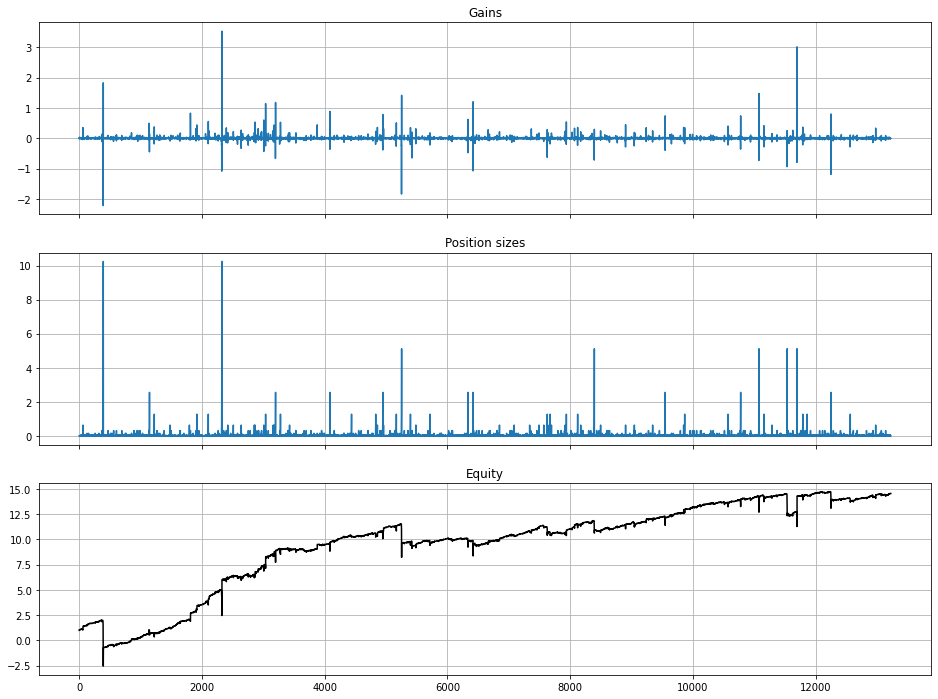

In [31]:
# Amount of positions:
print("Num positinos: "+str(len(prev_positions)))
f, [ax1, ax2, ax3] = plt.subplots(3, sharex=True, sharey=False, figsize=(16, 12))

#ax1.bar(list(range(len(prev_positions))), [pi['gain'] for pi in prev_positions], label="Gains")
gains=[pi['gain'] for pi in prev_positions]
#print(gains)
ax1.plot(gains, label="Gains")
ax1.set_title("Gains")

ax1.grid()

qtys=[pi['qty']for pi in prev_positions]
ax2.plot(qtys)
ax2.set_title("Position sizes")
ax2.grid()

ax3.plot(acc_vals, color="k")
ax3.set_title("Equity")
ax3.grid()


Now lets have a look on the risk involved: for now, we look at the histogram of all negative gains

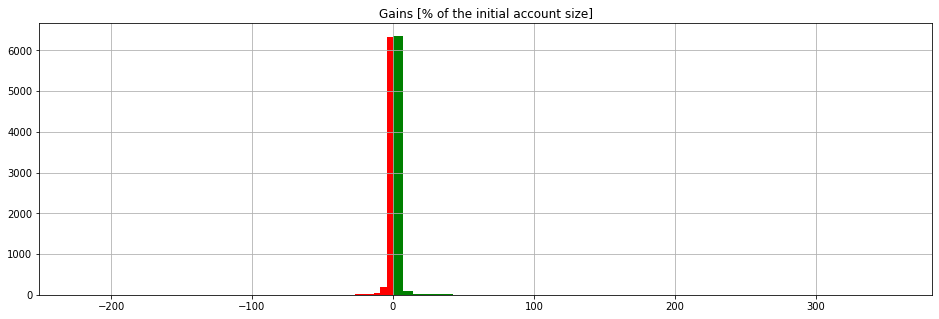

In [32]:
gains=np.array(gains)
pos_gains=gains[gains>0]
losses=gains[gains<0]#np.argwhere(np.array(gains) <0)

f, ax1 = plt.subplots(1, sharex=True, sharey=False, figsize=(16, 5))

ax1.hist(losses*100, color="red", bins=50)
ax1.hist(pos_gains*100, color="green", bins=50)
ax1.set_title("Gains [% of the initial account size]")
ax1.grid()

# Conclusion 

The probabilities shifted towards 50% /50% using ATR. At least for atr_N=14 and eps=0.3.

TBD: more conclusions to add here



